In [ ]:
# this works on ChIP-Seq and ATAC-Seq for normal and malignant HSPC, cell lines, 
this is a supplement for nb_TE_HSC_ATAC.ipynb

# import pacakges

In [33]:
share_dir

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/share_data/"

In [10]:
library(data.table)
library(dplyr)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(clusterProfiler)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(ggplot2)
library(gridExtra)
library(R.utils)
library(IRdisplay)
library(ChIPpeakAnno)
library(tidyverse)
library(SingleCellExperiment)
library(scDblFinder)
library(DT)
library(rtracklayer)
library(DBI)
library(Gviz)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene


options(width = 188)

In [11]:
data_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/'


In [12]:
path = paste0(Sys.getenv('PATH'), ':', '/home/whu78/conda3/envs/feb24/bin:/home/whu78/conda3/envs/feb24/condabin:/hpcf/user_commands:/usr/NX/bin:/cm/local/apps/environment-modules/4.5.3/bin:/hpcf/lsf/lsf_prod/10.1/linux3.10-glibc2.17-x86_64/etc:/hpcf/lsf/lsf_prod/10.1/linux3.10-glibc2.17-x86_64/bin:/usr/lpp/mmfs/bin:/usr/lpp/mmfs/lib:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/usr/sbin:/cm/local/apps/environment-modules/4.5.3/bin:/usr/sbin:/sbin:/bin:/usr/bin:/etc:/usr/ucb:/usr/local/bin:/usr/local/local_dfs/bin:/usr/bin/X11:/usr/local/sas:/home/whu78/.local/bin:/home/whu78/bin')
path = unique(unlist(strsplit(path, ':')))
path = c(path, '/home/whu78/edirect/')
path = paste(path, collapse = ':')
Sys.setenv('PATH' = path)


In [13]:
enh_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/'
base_dir = enh_dir


In [14]:
setwd(enh_dir)


In [15]:
source('~/script/utils.r')

# import atac-seq design table
samples has been processed here: nb_TE_HSC_ATAC

In [20]:
dsn_atac = fread('../../collab_Farhan/data/dsn_te_atac_merged_bak.txt')
head(dsn_atac[, .(sample_name_manual, srr_id, gsm_id)])

sample_name_manual,srr_id,gsm_id
<chr>,<chr>,<chr>
D4983_HSC_1,SRR2920466,GSM1937376
D4983_HSC_1,SRR2920467,GSM1937377
D4983_HSC_1,SRR2920468,GSM1937378
D4983_HSC_1,SRR2920469,GSM1937379
D4983_HSC_1,SRR2920470,GSM1937380
D4983_HSC_1,SRR2920471,GSM1937381


# import GSE231486 ChIPSeq sample information
ChIP-Seq and HI-C seq, no atac-seq


In [28]:
dsn_gse231486 = fread('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/gse231486_table') 
head(dsn_gse231486)


gsm_id,tag
<chr>,<chr>
GSM7277346,ChIPmentation_CMP_ERG_rep1
GSM7277347,ChIPmentation_CMP_ERG_rep2
GSM7277348,ChIPmentation_CMP_ERG_rep3
GSM7277349,ChIPmentation_CMP_FLI1_rep1
GSM7277350,ChIPmentation_CMP_FLI1_rep2
GSM7277351,ChIPmentation_CMP_FLI1_rep3


In [29]:
datatable(dsn_gse231486)

HTML widgets cannot be represented in plain text (need html)

In [31]:
dsn_gse231486[, nn := length(unlist(strsplit(.SD$tag, '_'))), by = 1:nrow(dsn_gse231486)]
table(dsn_gse231486$nn)



  4 
156 

In [32]:
dsn_gse231486[, assay := sub("(.*)_(.*)_(.*)_(.*)", "\\1", tag)]
dsn_gse231486[, cell_type := sub("(.*)_(.*)_(.*)_(.*)", "\\2", tag)]
dsn_gse231486[, antibody := sub("(.*)_(.*)_(.*)_(.*)", "\\3", tag)]
dsn_gse231486[, rep := sub("(.*)_(.*)_(.*)_(.*)", "\\4", tag)]

dsn_gse231486[, sample_name := paste0(cell_type, '_', antibody, '_', rep)]
dsn_gse231486[, sample_name := tag]

dim(dsn_gse231486)


[1] 156   8

In [614]:
head(dsn_gse231486)

gsm_id,tag,nn,assay,cell_type,antibody,rep,sample_name
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM7277346,ChIPmentation_CMP_ERG_rep1,4,ChIPmentation,CMP,ERG,rep1,ChIPmentation_CMP_ERG_rep1
GSM7277347,ChIPmentation_CMP_ERG_rep2,4,ChIPmentation,CMP,ERG,rep2,ChIPmentation_CMP_ERG_rep2
GSM7277348,ChIPmentation_CMP_ERG_rep3,4,ChIPmentation,CMP,ERG,rep3,ChIPmentation_CMP_ERG_rep3
GSM7277349,ChIPmentation_CMP_FLI1_rep1,4,ChIPmentation,CMP,FLI1,rep1,ChIPmentation_CMP_FLI1_rep1
GSM7277350,ChIPmentation_CMP_FLI1_rep2,4,ChIPmentation,CMP,FLI1,rep2,ChIPmentation_CMP_FLI1_rep2
GSM7277351,ChIPmentation_CMP_FLI1_rep3,4,ChIPmentation,CMP,FLI1,rep3,ChIPmentation_CMP_FLI1_rep3


In [616]:
dsn_gse231486[, srr_id := {system(paste0('~/edirect/esearch -db sra -query "', gsm_id, '" | efetch -format docsum | accn-at-a-time | grep -i srr | tr [:lower:] [:upper:] | tr "\n" "," '), 
                                   intern = T)}, by = 1:nrow(dsn_gse231486)]
head(dsn_gse231486)
#fwrite(dsn_gse231486, file = 'dsn_gse231486.tsv')


gsm_id,tag,nn,assay,cell_type,antibody,rep,sample_name,srr_id
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM7277346,ChIPmentation_CMP_ERG_rep1,4,ChIPmentation,CMP,ERG,rep1,ChIPmentation_CMP_ERG_rep1,"SRR24388802,"
GSM7277347,ChIPmentation_CMP_ERG_rep2,4,ChIPmentation,CMP,ERG,rep2,ChIPmentation_CMP_ERG_rep2,"SRR24388801,"
GSM7277348,ChIPmentation_CMP_ERG_rep3,4,ChIPmentation,CMP,ERG,rep3,ChIPmentation_CMP_ERG_rep3,"SRR24388800,"
GSM7277349,ChIPmentation_CMP_FLI1_rep1,4,ChIPmentation,CMP,FLI1,rep1,ChIPmentation_CMP_FLI1_rep1,"SRR24388799,"
GSM7277350,ChIPmentation_CMP_FLI1_rep2,4,ChIPmentation,CMP,FLI1,rep2,ChIPmentation_CMP_FLI1_rep2,"SRR24388798,"
GSM7277351,ChIPmentation_CMP_FLI1_rep3,4,ChIPmentation,CMP,FLI1,rep3,ChIPmentation_CMP_FLI1_rep3,"SRR24388797,"


In [34]:
dsn_gse231486 = fread('dsn_gse231486.tsv')
dsn_gse231486[, srr_ids := sub(',$', '', srr_id)]
#dsn_gse231486 = dsn_gse231486[, .(srr_id = unlist(tstrsplit(sra_id, '_', type.convert = TRUE))), by = 'sample_name']
dsn_gse231486 = dsn_gse231486 %>% 
group_by(sample_name) %>% 
separate_rows(srr_ids, sep = ",") %>% 
filter(!is.na(srr_ids))
dsn_gse231486 = as.data.table(dsn_gse231486)
dsn_gse231486[antibody == 'PU.1', antibody := 'PU1']
#dsn_gse231486 = dsn_gse231486[!is.na(srr_id), ]
head(dsn_gse231486)


gsm_id,tag,assay,cell_type,antibody,rep,sample_name,srr_id,srr_ids
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM7277346,ChIPmentation_CMP_ERG_rep1,ChIPmentation,CMP,ERG,rep1,ChIPmentation_CMP_ERG_rep1,"SRR24388802,",SRR24388802
GSM7277347,ChIPmentation_CMP_ERG_rep2,ChIPmentation,CMP,ERG,rep2,ChIPmentation_CMP_ERG_rep2,"SRR24388801,",SRR24388801
GSM7277348,ChIPmentation_CMP_ERG_rep3,ChIPmentation,CMP,ERG,rep3,ChIPmentation_CMP_ERG_rep3,"SRR24388800,",SRR24388800
GSM7277349,ChIPmentation_CMP_FLI1_rep1,ChIPmentation,CMP,FLI1,rep1,ChIPmentation_CMP_FLI1_rep1,"SRR24388799,",SRR24388799
GSM7277350,ChIPmentation_CMP_FLI1_rep2,ChIPmentation,CMP,FLI1,rep2,ChIPmentation_CMP_FLI1_rep2,"SRR24388798,",SRR24388798
GSM7277351,ChIPmentation_CMP_FLI1_rep3,ChIPmentation,CMP,FLI1,rep3,ChIPmentation_CMP_FLI1_rep3,"SRR24388797,",SRR24388797


In [621]:
length(dsn_gse231486[!is.na(srr_ids), srr_ids])

[1] 190

In [622]:
table(dsn_gse231486$antibody)


    CTCF      ERG     FLI1    GATA2  H3K27ac  H3K27AC H3K27me3  H3K4me3      HiC      IgG     LMO2     LYL1     Pol2      PU1    RUNX1    STAG2     TAL1 
      14       14       14       14        4       10        4        4       16        4       14       14       10       14       14       12       14 

In [623]:
table(dsn_gse231486$cell_type)



CMP GMP HSC MEP 
 41  52  43  54 

In [36]:
table(dsn_gse231486$cell_type, dsn_gse231486$antibody, dsn_gse231486$assay)


, ,  = ChIP

     
      CTCF ERG FLI1 GATA2 H3K27ac H3K27AC H3K27me3 H3K4me3 HiC IgG LMO2 LYL1 Pol2 PU1 RUNX1 STAG2 TAL1
  CMP    0   0    0     0       1       0        0       1   0   0    0    0    0   0     0     0    0
  GMP    0   0    0     0       1       0        0       1   0   0    0    0    0   0     0     0    0
  HSC    0   0    0     0       1       0        0       1   0   0    0    0    0   0     0     0    0
  MEP    0   0    0     0       1       0        0       1   0   0    0    0    0   0     0     0    0

, ,  = ChIPmentation

     
      CTCF ERG FLI1 GATA2 H3K27ac H3K27AC H3K27me3 H3K4me3 HiC IgG LMO2 LYL1 Pol2 PU1 RUNX1 STAG2 TAL1
  CMP    3   3    3     3       0       0        1       0   0   1    3    3    2   3     3     2    3
  GMP    4   4    4     4       0       0        1       0   0   1    4    4    2   4     4     4    4
  HSC    3   3    3     3       0       0        1       0   0   1    3    3    2   3     3     2    3
  MEP    4   4    4     4

In [624]:
table(dsn_gse231486$assay)
table(dsn_gse231486$antibody)



         ChIP ChIPmentation           HiC        HiChIP 
            8           156            16            10 


    CTCF      ERG     FLI1    GATA2  H3K27ac  H3K27AC H3K27me3  H3K4me3      HiC      IgG     LMO2     LYL1     Pol2      PU1    RUNX1    STAG2     TAL1 
      14       14       14       14        4       10        4        4       16        4       14       14       10       14       14       12       14 

# bloodChIP extra
for cell lines chip-seq and atac-seq

In [37]:
dsn_bloodx = fread('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/table2')
setnames(dsn_bloodx, c('cell_type', 'antibody', 'pmid', 'accession', 'sra_id'))
dsn_bloodx[, tag := paste0(cell_type, '_', antibody)]
dsn_bloodx[, index := 1:nrow(dsn_bloodx)]
dsn_bloodx = relocate(dsn_bloodx, 'index')

dsn_bloodx[, assay := 'ChIP'] 
dsn_bloodx[antibody == 'ATAC', assay := 'ATAC'] 

cell_lines = c('Kasumi1', 'KG1', 'ME1', 'TSU1621MT')
dsn_bloodx = dsn_bloodx[cell_type %in% cell_lines, ]
dsn_bloodx[, sample_name := paste0(assay, '_', cell_type, '_', antibody, '_rep1')]
#dsn_bloodx = dsn_bloodx[, .(srr_id = unlist(tstrsplit(sra_id, '_', type.convert = TRUE))), by = 'sample_name']

#dsn_bloodx[, cell_type := sub('(.*)_(.*)_(.*)', '\\1', sample_name)]
#dsn_bloodx[, antibody := sub('(.*)_(.*)_(.*)', '\\2', sample_name)]
#dsn_bloodx[, rep := sub('(.*)_(.*)_(.*)', '\\3', sample_name)]
dsn_bloodx = dsn_bloodx %>% group_by(sample_name) %>% separate_rows(sra_id, sep = '_') %>% filter(!is.na(sra_id)) 
dsn_bloodx = as.data.table(dsn_bloodx)
dsn_bloodx[antibody == 'PU.1', antibody := 'PU1']
head(dsn_bloodx)


index,cell_type,antibody,pmid,accession,sra_id,tag,assay,sample_name
<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Kasumi1,ATAC,34010414,E-MTAB-9021,ERR4084850,Kasumi1_ATAC,ATAC,ATAC_Kasumi1_ATAC_rep1
1,Kasumi1,ATAC,34010414,E-MTAB-9021,ERR4084851,Kasumi1_ATAC,ATAC,ATAC_Kasumi1_ATAC_rep1
1,Kasumi1,ATAC,34010414,E-MTAB-9021,ERR4084852,Kasumi1_ATAC,ATAC,ATAC_Kasumi1_ATAC_rep1
2,Kasumi1,ERG,27851970,GSM2026052,SRR3082396,Kasumi1_ERG,ChIP,ChIP_Kasumi1_ERG_rep1
3,Kasumi1,FLI1,27851970,GSM2026051,SRR3082395,Kasumi1_FLI1,ChIP,ChIP_Kasumi1_FLI1_rep1
4,Kasumi1,GATA2,27851970,GSM2026054,SRR3082398,Kasumi1_GATA2,ChIP,ChIP_Kasumi1_GATA2_rep1


In [24]:
table(dsn_bloodx$antibody, dsn_bloodx$cell_type)


         
          Kasumi1 KG1 ME1 TSU1621MT
  ATAC          3   2   2         0
  ERG           1   1   1         1
  FLI1          1   1   1         1
  GATA2         1   1   1         1
  H3K27Ac       1   1   1         0
  IgG           0   1   1         0
  LMO2          1   1   1         1
  LYL1          1   1   1         1
  PU1           1   1   1         1
  RNAseq        0   0   0         2
  RUNX1         1   1   1         1
  TAL1          1   1   1         1

In [38]:
dsn = rbind(dsn_bloodx[, .(sample_name, assay, cell_type, antibody, sra_id)], dsn_gse231486[, .(sample_name, assay, cell_type, antibody, srr_ids)], use.names = F)
setnames(dsn, 'sra_id', 'srr_id')
head(dsn)


sample_name,assay,cell_type,antibody,srr_id
<chr>,<chr>,<chr>,<chr>,<chr>
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084850
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084851
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084852
ChIP_Kasumi1_ERG_rep1,ChIP,Kasumi1,ERG,SRR3082396
ChIP_Kasumi1_FLI1_rep1,ChIP,Kasumi1,FLI1,SRR3082395
ChIP_Kasumi1_GATA2_rep1,ChIP,Kasumi1,GATA2,SRR3082398


In [39]:
fwrite(dsn, file = 'dsn_oct23.tsv')
#fwrite(dsn, file = 'dsn_step2.tsv')

In [11]:
dsn = fread(paste0(enh_dir, 'dsn_oct23.tsv'))
head(dsn)


sample_name,assay,cell_type,antibody,srr_id
<chr>,<chr>,<chr>,<chr>,<chr>
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084850
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084851
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084852
ChIP_Kasumi1_ERG_rep1,ChIP,Kasumi1,ERG,SRR3082396
ChIP_Kasumi1_FLI1_rep1,ChIP,Kasumi1,FLI1,SRR3082395
ChIP_Kasumi1_GATA2_rep1,ChIP,Kasumi1,GATA2,SRR3082398


In [17]:
dsn[assay == 'ATAC' , ]

sample_name,assay,cell_type,antibody,srr_id
<chr>,<chr>,<chr>,<chr>,<chr>
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084850
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084851
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084852
ATAC_KG1_ATAC_rep1,ATAC,KG1,ATAC,SRR13800827
ATAC_KG1_ATAC_rep1,ATAC,KG1,ATAC,SRR13800828
ATAC_ME1_ATAC_rep1,ATAC,ME1,ATAC,SRR5861512
ATAC_ME1_ATAC_rep1,ATAC,ME1,ATAC,SRR5861513


In [ ]:
table(dsn$cell_type, dsn$antibody, dsn$assay)

# download fastq files

In [12]:
dsn[, sample_dir := paste0(data_dir, sample_name, '/')]
dsn[, sra_file := paste0(sample_dir, srr_id, '/', srr_id, '.sra')]  
dsn[, base_sra_file := basename(sra_file) ]
head(dsn)


sample_name,assay,cell_type,antibody,srr_id,sample_dir,sra_file,base_sra_file
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084850,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1/,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1/ERR4084850/ERR4084850.sra,ERR4084850.sra
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084851,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1/,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1/ERR4084851/ERR4084851.sra,ERR4084851.sra
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084852,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1/,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1/ERR4084852/ERR4084852.sra,ERR4084852.sra
ChIP_Kasumi1_ERG_rep1,ChIP,Kasumi1,ERG,SRR3082396,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_Kasumi1_ERG_rep1/,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_Kasumi1_ERG_rep1/SRR3082396/SRR3082396.sra,SRR3082396.sra
ChIP_Kasumi1_FLI1_rep1,ChIP,Kasumi1,FLI1,SRR3082395,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_Kasumi1_FLI1_rep1/,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_Kasumi1_FLI1_rep1/SRR3082395/SRR3082395.sra,SRR3082395.sra
ChIP_Kasumi1_GATA2_rep1,ChIP,Kasumi1,GATA2,SRR3082398,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_Kasumi1_GATA2_rep1/,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_Kasumi1_GATA2_rep1/SRR3082398/SRR3082398.sra,SRR3082398.sra


In [13]:
sra = fread('/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/sra_list')
sra[, base_fname := basename(fname)]
sra[, full_fname := paste0('/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/', fname)]
head(sra)

fname,base_fname,full_fname
<chr>,<chr>,<chr>
./HSC_ERG_rep2/SRR24388756/SRR24388756.sra,SRR24388756.sra,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/./HSC_ERG_rep2/SRR24388756/SRR24388756.sra
./HSC_LMO2_rep2/SRR24388746/SRR24388746.sra,SRR24388746.sra,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/./HSC_LMO2_rep2/SRR24388746/SRR24388746.sra
./MEP_LMO2_rep2/SRR24388650/SRR24388650.sra,SRR24388650.sra,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/./MEP_LMO2_rep2/SRR24388650/SRR24388650.sra
./TSU1621MT_RUNX1_rep1/SRR1552858/SRR1552858.sra,SRR1552858.sra,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/./TSU1621MT_RUNX1_rep1/SRR1552858/SRR1552858.sra
./CMP_ERG_rep3/SRR24388800/SRR24388800.sra,SRR24388800.sra,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/./CMP_ERG_rep3/SRR24388800/SRR24388800.sra
./HSC_ERG_rep3/SRR24388755/SRR24388755.sra,SRR24388755.sra,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/./HSC_ERG_rep3/SRR24388755/SRR24388755.sra


In [14]:
dsn = merge(dsn, sra, by.x = 'base_sra_file', by.y = 'base_fname', all.x = T)

In [ ]:
dsn[, {dir.create(sample_dir, showWarnings = F, recursive = F)}, by = 1:nrow(dsn)]

In [16]:
dsn[, ori_dir := sub('SRR.*', '', full_fname)]
dsn[, cmd := paste0('mv ', ori_dir, '*.fastq.gz ', sample_dir)]
write(dsn[dir.exists(ori_dir), cmd], file = 'run_rename.sh')

In [ ]:
head(dsn)

In [17]:
dsn[, prefetch_cmd := paste0('prefetch ',     srr_id, ' -O ', sample_dir, ' --max-size 40g')]
dsn[, fastqdump_cmd:= paste0('cd ', sample_dir, ' && fasterq-dump ', srr_id, ' --outdir ', sample_dir)]

# if single end seq
dsn[, dump_r := paste0(sample_dir,  '/', srr_id, '.fastq')]
# if double end seq
dsn[, dump_r1 := paste0(sample_dir, '/', srr_id, '_1.fastq')] 
dsn[, dump_r2 := paste0(sample_dir, '/', srr_id, '_2.fastq')]

dsn[, gz_r_cmd := paste0(' gzip ', dump_r, ' &' )]
dsn[, gz_r1_cmd := paste0(' gzip ', dump_r1, ' &' )]
dsn[, gz_r2_cmd := paste0(' gzip ', dump_r2, ' &' )]

dsn[, r_fastq_gz := paste0(dump_r, '.gz')]
dsn[, r1_fastq_gz := paste0(dump_r1, '.gz')]
dsn[, r2_fastq_gz := paste0(dump_r2, '.gz')]


In [18]:
# Single End sequenceing or Double end sequencing
dsn[, sede := 'se'] 
dsn[file.exists(r2_fastq_gz) & file.size(r2_fastq_gz) > 1000, sede := 'de']

dsn[sede == 'se', r1_fastq_gz := r_fastq_gz ]


In [710]:
table(dsn$sede)


 de  se 
172  64 

In [44]:
table(dsn[sede == 'se', cell_type])
table(dsn[sede == 'se', antibody])


      CMP   Kasumi1       KG1       ME1 TSU1621MT 
       28        11         9         6        10 


   ATAC    CTCF     ERG    FLI1   GATA2 H3K27Ac     IgG    LMO2    LYL1     PU1 
      3       3       7       7       7       1       2       6       6       7 
 RNAseq   RUNX1    TAL1 
      2       7       6 

In [712]:
table(dsn[antibody == 'PU1', cell_type])


CMP GMP HSC MEP 
  3   4   3   4 

In [713]:
dsn[!file.exists(r1_fastq_gz) & sede == 'de', r1_fastq_gz]
dsn[!file.exists(r2_fastq_gz) & sede == 'de', r2_fastq_gz]
dsn[!file.exists(r1_fastq_gz) & sede == 'se', r1_fastq_gz]


character(0)

character(0)

character(0)

In [103]:
write(dsn[grep('SRR', srr_id), prefetch_cmd], file = 'run_batch3_prefetch.sh')
dsn[grep('SRR', srr_id), prefetch_cmd][1]


[1] "prefetch SRR3082396 -O /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/Kasumi1_ERG_rep1/ --max-size 40g"

In [ ]:
write(dsn[, fastqdump_cmd], file = 'run_batch3_fastq_dump.sh')
write(dsn[file.exists(dump_r),  gz_r_cmd],  file = 'run_gzip.sh')
write(dsn[file.exists(dump_r1), gz_r1_cmd], file = 'run_gzip.sh', append = T)
write(dsn[file.exists(dump_r2), gz_r2_cmd], file = 'run_gzip.sh', append = T)


In [135]:
write(dsn[grepl('SRR', srr_id) & !file.exists(dsn$sra_file), prefetch_cmd], file = 'run_batch3_prefetch.sh')
write(dsn[grepl('SRR', srr_id), fastqdump_cmd], file = 'run_batch3_fastq.sh')


In [599]:
all(file.exists(dsn$sra_file[4:length(dsn$sra_file)]))

[1] FALSE

In [45]:
all(file.exists(dsn$r1_fastq_gz))

[1] TRUE

In [714]:
#fwrite(dsn, file = 'dsn_before_merge_may28.tsv')
#dsn = fread('dsn_before_merge.tsv')
#dim(dsn)


In [19]:
base_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/' 


In [50]:
nrow(dsn[file.exists(r2_fastq_gz), ])

[1] 172

In [46]:
head(dsn[, .(sample_name, assay, cell_type, antibody, srr_id, r_fastq_gz, r1_fastq_gz, r2_fastq_gz)])

sample_name,assay,cell_type,antibody,srr_id,r_fastq_gz,r1_fastq_gz,r2_fastq_gz
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084850,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1//ERR4084850.fastq.gz,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1//ERR4084850.fastq.gz,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1//ERR4084850_2.fastq.gz
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084851,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1//ERR4084851.fastq.gz,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1//ERR4084851.fastq.gz,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1//ERR4084851_2.fastq.gz
ATAC_Kasumi1_ATAC_rep1,ATAC,Kasumi1,ATAC,ERR4084852,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1//ERR4084852.fastq.gz,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1//ERR4084852.fastq.gz,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ATAC_Kasumi1_ATAC_rep1//ERR4084852_2.fastq.gz
ChIP_KG1_ERG_rep1,ChIP,KG1,ERG,SRR12746526,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_KG1_ERG_rep1//SRR12746526.fastq.gz,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_KG1_ERG_rep1//SRR12746526.fastq.gz,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_KG1_ERG_rep1//SRR12746526_2.fastq.gz
ChIP_KG1_FLI1_rep1,ChIP,KG1,FLI1,SRR12746527,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_KG1_FLI1_rep1//SRR12746527.fastq.gz,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_KG1_FLI1_rep1//SRR12746527.fastq.gz,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_KG1_FLI1_rep1//SRR12746527_2.fastq.gz
ChIP_KG1_GATA2_rep1,ChIP,KG1,GATA2,SRR12746528,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_KG1_GATA2_rep1//SRR12746528.fastq.gz,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_KG1_GATA2_rep1//SRR12746528.fastq.gz,/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/ATAC-seq/Hematopoietic_lineages_batch3/ChIP_KG1_GATA2_rep1//SRR12746528_2.fastq.gz


# merge lanes for a same sample

In [14]:
proj_name = 'chip'


In [21]:
base_dir

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/"

In [22]:
enh_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/'

In [23]:
dsn[, tag := paste0(assay, '_', cell_type, '_', antibody) ]

In [21]:
dim(dsn[!duplicated(tag), ])

[1] 109   6

In [49]:
dsn[, nn := nrow(.SD), by = 'tag' ]


In [24]:
table(dsn$nn)


  1   2   3   4 
 53  22  57 104 

In [25]:
dsn[, nn := nrow(.SD), by = 'tag' ]
dsn[, sample_dir2 := paste0(enh_dir, 'work/', tag, '/')]


In [312]:
inv = dsn[, {dir.create(sample_dir2, showWarnings = F, recursive = T)}, by = 1:nrow(dsn)] 


In [26]:
dsn[, r1_sample := paste0(sample_dir2, tag, '_R1.fastq.gz')]
dsn[, r2_sample := paste0(sample_dir2, tag, '_R2.fastq.gz')]


In [ ]:
inv = dsn[, {if(.SD$nn == 1){createLink(link = .SD$r1_sample, target = .SD$r1_fastq_gz)}}, by = 1:nrow(dsn)] 
inv = dsn[, {if(.SD$nn == 1 & file.exists(.SD$r2_fastq_gz) & file.size(.SD$r2_fastq_gz) > 1000){createLink(link = .SD$r2_sample, target = .SD$r2_fastq_gz)}}, by = 1:nrow(dsn)] 


In [28]:
dim(dsn)

[1] 236   8

In [27]:
setwd(enh_dir)

In [28]:
dsn[, mergeR1_jobname := paste0('mergeR1_', tag)]
dsn[, mergeR1_oo := paste0(sample_dir2, tag, '_', mergeR1_jobname, '_out')]
dsn[, mergeR1_eo := paste0(sample_dir2, tag, '_', mergeR1_jobname, '_err')]
dsn[, mergeR1_cmd := paste0('bsub -J ', mergeR1_jobname, ' -n 10 -o ', mergeR1_oo, ' -e ', mergeR1_eo)]
dsn[, mergeR1_cmd := paste0(mergeR1_cmd, ' -n 2 -R "rusage[mem=5GB]" -R "span[hosts=1]" -W 290:00 ')]
dsn[, mergeR1_cmd := paste0(mergeR1_cmd, ' " cat ', paste(.SD$r1_fastq_gz, collapse = ' '), ' > ', r1_sample, '"'), by = 'tag']

write(dsn[nn > 1, ][!duplicated(tag), mergeR1_cmd], file = paste0('run_', proj_name, '_r1_mergeR1.sh'))


In [29]:
dsn[, mergeR2_jobname := paste0('cuta_', tag)]
dsn[, mergeR2_oo := paste0(sample_dir2, tag, '_', mergeR2_jobname, '_out')]
dsn[, mergeR2_eo := paste0(sample_dir2, tag, '_', mergeR2_jobname, '_err')]
dsn[, mergeR2_cmd := paste0('bsub -J ', mergeR2_jobname, ' -n 10 -o ', mergeR2_oo, ' -e ', mergeR2_eo)]
dsn[, mergeR2_cmd := paste0(mergeR2_cmd, ' -n 2 -R "rusage[mem=5GB]" -R "span[hosts=1]" -W 290:00 ')]
dsn[, mergeR2_cmd := paste0(mergeR2_cmd, ' " cat ', paste(.SD$r2_fastq_gz, collapse = ' '), ' > ', r2_sample, '"'), by = 'tag']

write(dsn[nn > 1 & sede == 'de', ][!duplicated(tag), mergeR2_cmd], file = paste0('run_', proj_name, '_r2_mergeR2.sh'))


In [203]:
table(dsn$cell_type) 


      CMP       GMP       HSC   Kasumi1       KG1       ME1       MEP TSU1621MT 
       41        52        43        12        12        12        54        10 

In [294]:
getwd()

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan"

In [30]:
dsn_sample = dsn[!duplicated(sample_name) , ]
dsn_sample[, sample_dir := sample_dir2] 


In [83]:
nrow(dsn[!duplicated(sample_dir2), ])

[1] 197

In [30]:
nrow(dsn)
nrow(dsn_sample)

[1] 236

[1] 197

In [31]:
head(dsn_sample$sample_name)

[1] "ATAC_Kasumi1_ATAC_rep1" "ChIP_KG1_ERG_rep1"      "ChIP_KG1_FLI1_rep1"     "ChIP_KG1_GATA2_rep1"    "ChIP_KG1_H3K27Ac_rep1"  "ChIP_KG1_IgG_rep1"

In [32]:
colnames(dsn_sample) 

[1] "base_sra_file"      "sample_name"        "assay"              "cell_type"          "antibody"           "srr_id"             "sample_dir"         "sra_file"          
 [9] "fname"              "full_fname"         "prefetch_cmd"       "fastqdump_cmd"      "dump_r"             "dump_r1"            "dump_r2"            "gz_r_cmd"          
[17] "gz_r1_cmd"          "gz_r2_cmd"          "r_fastq_gz"         "r1_fastq_gz"        "r2_fastq_gz"        "nn"                 "sample_dir2"        "r1_sample"         
[25] "r2_sample"          "r1_fastq_gz_size"   "r2_fastq_gz_size"   "r1_sample_size_cal" "r2_sample_size_cal" "mergeR1_jobname"    "mergeR1_oo"         "mergeR1_eo"        
[33] "mergeR1_cmd"        "mergeR2_jobname"    "mergeR2_oo"         "mergeR2_eo"         "mergeR2_cmd"        "sede"               "r1_trimmed"         "r2_trimmed"        
[41] "cutadapt_jobname"   "cutadapt_oo"        "cutadapt_eo"        "cutadapt_cmd"       "fname_pre"          "bow2_jobname"       "bow2_oo"            "bow2_eo"           
[49] "sam_file"           "sam_report_file"    "bow2_cmd"           "sam2bam_jobname"    "sam2bam_oo"         "sam2bam_eo"         "bam_file"           "sam2bam_cmd"       
[57] "bam2bed_jobname"    "bam2bed_oo"         "bam2bed_eo"         "bed_file"           "bam2bed_cmd"        "wig_file"           "macs2_jobname"      "macs2_oo"          
[65] "macs2_eo"           "macs2_cmd"          "bigwig_file"        "bed2wig2_jobname"   "bed2wig2_oo"        "bed2wig2_eo"        "bed2wig2_cmd"

In [33]:
head(dsn_sample$sample_dir2)
head(dsn_sample$sample_dir)

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_Kasumi1_ATAC_rep1/"
[2] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_ERG_rep1/"     
[3] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_FLI1_rep1/"    
[4] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_GATA2_rep1/"   
[5] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_H3K27Ac_rep1/" 
[6] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_IgG_rep1/"

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_Kasumi1_ATAC_rep1/"
[2] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_ERG_rep1/"     
[3] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_FLI1_rep1/"    
[4] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_GATA2_rep1/"   
[5] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_H3K27Ac_rep1/" 
[6] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_IgG_rep1/"

In [755]:
nrow(dsn_sample[nn > 1, ])
nrow(dsn_sample[nn == 1, ])

[1] 38

[1] 159

# export design table

In [31]:
#fwrite(dsn, file = 'dsn_oct24.tsv')
fwrite(dsn, file = 'dsn_oct30.tsv')
fwrite(dsn_sample, file = 'dsn_sample_oct30.tsv')

In [749]:
#fwrite(dsn, file = 'before_cutadapt.tsv')


In [34]:
dsn = fread('dsn_oct24.tsv')

In [37]:
table(dsn$antibody)


    ATAC     CTCF      ERG     FLI1    GATA2  H3K27ac  H3K27Ac  H3K27AC H3K27me3  H3K4me3      HiC      IgG     LMO2     LYL1     Pol2      PU1   RNAseq    RUNX1    STAG2     TAL1 
       3       12       16       16       16        4        3        8        4        4        8        6       16       16        8       16        1       16        8       16 

In [29]:
fwrite(dsn[, .(sample_name, cell_type, antibody, srr_id, r1_fastq_gz, r2_fastq_gz)], 
      file = paste0(base_dir, 'share_table_hema_ChIPSeq_ATACSeq.tsv'), sep = '\t')


In [36]:
dsn = fread('dsn_sample_oct30.tsv')

# cutadapt

In [27]:
# if start from here
dsn = fread('~/WenhuoHu/TE//enhancer/dsn_oct30.tsv')

In [38]:
proj_name = 'enh'

In [39]:
dsn_sample = dsn[!duplicated(tag), ]
dsn_sample[, sample_name := tag ]


In [41]:
# module load cutadapt/4.4

dsn_sample[, r1_trimmed := paste0(sample_dir2, sample_name, '_R1_trimmed.fa.gz')]
dsn_sample[, r2_trimmed := paste0(sample_dir2, sample_name, '_R2_trimmed.fa.gz')]

dsn_sample[, cutadapt_jobname := paste0('cuta_', sample_name, '_', proj_name)]
dsn_sample[, cutadapt_oo := paste0(sample_dir2, cutadapt_jobname, '_out')]
dsn_sample[, cutadapt_eo := paste0(sample_dir2, cutadapt_jobname, '_err')]
dsn_sample[, cutadapt_cmd := paste0('bsub -J ', cutadapt_jobname, ' -o ', cutadapt_oo, ' -e ', cutadapt_eo)]
dsn_sample[, cutadapt_cmd := paste0(cutadapt_cmd, ' -n 10 -R "rusage[mem=5GB]" -R "span[hosts=1]" -W 290:00 ')]

# if paired end sequencing 
dsn_sample[file.exists(r2_fastq_gz) & file.size(r2_fastq_gz) > 1000,  cutadapt_cmd := paste0(cutadapt_cmd, ' " cutadapt -o ', r1_trimmed, ' -p ', r2_trimmed, ' ', r1_sample, ' ', r2_sample, '"')]

# if single end sequencing 
dsn_sample[!file.exists(r2_fastq_gz) | file.size(r2_fastq_gz) < 1000, cutadapt_cmd := paste0(cutadapt_cmd, ' " cutadapt -o ', r1_trimmed, ' ', r1_sample, '"')]

write(dsn_sample[, cutadapt_cmd], file = paste0('run_enh_cutadapt.sh'))


In [44]:
file.exists(dsn_sample$r1_trimmed)
file.exists(dsn_sample$r2_trimmed)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [37] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [73] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[109] TRUE

[1] FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE
 [31]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [61]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [91]  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [46]:
dsn_sample[sede == 'se' & file.exists(r2_trimmed), ]

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"


base_sra_file,sample_name,assay,cell_type,antibody,srr_id,sample_dir,sra_file,fname,full_fname,⋯,mergeR2_jobname,mergeR2_oo,mergeR2_eo,mergeR2_cmd,r1_trimmed,r2_trimmed,cutadapt_jobname,cutadapt_oo,cutadapt_eo,cutadapt_cmd
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


In [42]:
dim(dsn_sample)

[1] 109  43

In [308]:
head(dsn[sede == 'de' & file.size(r2_fastq_gz) > 0 & !file.exists(r2_trimmed), r2_trimmed])
#file.exists(dsn[sede == 'de', r2_trimmed])

character(0)

# alignment

In [31]:
source('~/script/utils.r')

In [22]:
taxon = 't2t'
gnome = genome_fun(taxon) 

In [21]:
getwd()

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer"

In [322]:
table(dsn_sample$sede) 


de se 
66 43 

In [ ]:
https://depot.galaxyproject.org/singularity/bioconductor-rbowtie2:3A2.8.0--r43hf17093f_1

In [30]:
# module load bow2/2.7.10a
dsn_sample[, fname_pre := paste0(sample_dir2, sample_name, '_', taxon)]

dsn_sample[, bow2_jobname := paste0('bow2_', sample_name, '_', proj_name)]
dsn_sample[, bow2_oo := paste0(sample_dir2, bow2_jobname, '_out')]
dsn_sample[, bow2_eo := paste0(sample_dir2, bow2_jobname, '_err')]
dsn_sample[, sam_file := paste0(fname_pre, '.sam')]
dsn_sample[, bam_file := paste0(fname_pre, '.bam')]
dsn_sample[, sam_report_file := paste0(fname_pre, '_bowtie2Report.txt')]

# -k aln times
#jobs = fread(text = system('bjobs -w', intern = T))
dsn_sample[, bow2_cmd := paste0('bsub -J ', bow2_jobname, ' -o ', bow2_oo, ' -e ', bow2_eo)]
dsn_sample[, bow2_cmd := paste0(bow2_cmd, ' -n 30 -R "rusage[mem=5GB]" -R "span[hosts=1]" -W 290:00 ')]
#dsn_sample[cutadapt_jobname %in% jobs$JOB_NAME, bow2_cmd := paste0(bow2_cmd, ' -w "done(', cutadapt_jobname, ')" ')]
dsn_sample[, bow2_cmd := paste0(bow2_cmd, ' " singularity exec --bind ', sample_dir2, ' --bind ', gnome$bowtie2_index, ' ', sif$bowtie2)]

# if pair end
dsn_sample[sede == 'de', bow2_cmd := paste0(bow2_cmd, ' bowtie2 -k 100 -p 29 -x ', gnome$bowtie2_index, ' -1 ', r1_trimmed, ' -2 ', r2_trimmed)]
# if single end
dsn_sample[sede == 'se', bow2_cmd := paste0(bow2_cmd, ' bowtie2 -k 100 -p 29 -x ', gnome$bowtie2_index, ' -U ', r1_trimmed, ' ')]

#dsn_sample[, bow2_cmd := paste0(bow2_cmd, ' -S - | samtools view -b - > ', bam_file, '"')]
dsn_sample[, bow2_cmd := paste0(bow2_cmd, ' -S ', sam_file, ' " ') ]

write(dsn_sample[, bow2_cmd], file = paste0('run_enh_bow2.sh'))


In [31]:
getwd()

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer"

In [27]:
options(width = 166)

In [35]:
save(dsn_sample, dsn, file = 'dsn_var_2024nov18.rdata')

# sam to bam 

In [37]:
proj_enh = 'enh'

In [38]:
sif$samtools

[1] "/home/whu78/images/depot.galaxyproject.org-singularity-samtools-1.20--h50ea8bc_0.img"

In [113]:
dsn_sample[, sam2bam_jobname := paste0('sam2bam_', sample_name, '_', proj_enh)]
dsn_sample[, sam2bam_oo := paste0(sample_dir2, sam2bam_jobname, '_out')]
dsn_sample[, sam2bam_eo := paste0(sample_dir2, sam2bam_jobname, '_err')]
dsn_sample[, bam_file := paste0(fname_pre, '_sorted.bam')]

# -k aln times
jobs = fread(text = system('bjobs -w', intern = T))
dsn_sample[, sam2bam_cmd := paste0('bsub -J ', sam2bam_jobname, ' -o ', sam2bam_oo, ' -e ', sam2bam_eo) ]
dsn_sample[, sam2bam_cmd := paste0(sam2bam_cmd, ' -n 30 -R "rusage[mem=5GB]" -R "span[hosts=1]" -W 290:00 ')]
dsn_sample[bow2_jobname %in% jobs$JOB_NAME, sam2bam_cmd := paste0(sam2bam_cmd, ' -w "done(', bow2_jobname, ')" ')]
dsn_sample[, sam2bam_cmd := paste0(sam2bam_cmd, ' " singularity exec --bind ', sample_dir2, ' ', sif$samtools)]
dsn_sample[, sam2bam_cmd := paste0(sam2bam_cmd, ' samtools sort -@ 15 -m 5G -o ', bam_file, ' ', sam_file, ' "')]

write(dsn_sample[, sam2bam_cmd], file = paste0('run_enh_sam2bam.sh'))


Warning message in fread(text = system("bjobs -w", intern = T)):
“Detected 8 column names but the data has 10 columns (i.e. invalid file). Added 2 extra default column names at the end.”


In [68]:
getwd()

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer"

In [47]:
dsn_sample[1, sam2bam_cmd]

[1] "bsub -J sam2bam_ATAC_Kasumi1_ATAC_enh -o /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_Kasumi1_ATAC/sam2bam_ATAC_Kasumi1_ATAC_enh_out -e /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_Kasumi1_ATAC/sam2bam_ATAC_Kasumi1_ATAC_enh_err -n 30 -R \"rusage[mem=5GB]\" -R \"span[hosts=1]\" -W 290:00  \" singularity exec --bind /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_Kasumi1_ATAC/ /home/whu78/images/depot.galaxyproject.org-singularity-samtools-1.20--h50ea8bc_0.img \" samtools sort -@ 28 -m 5G -o /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_Kasumi1_ATAC/ATAC_Kasumi1_ATAC_t2t_sorted.bam /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_Kasumi1_ATAC/ATAC_Kasumi1_ATAC_t2t.sam \""

In [374]:
dsn_sample[, bam_check := NULL ]

In [ ]:
dsn_sample[, bam_check := system(paste0('samtools quickcheck -v ', .SD$bam_file, ' 2> '), intern = T), by = 1:nrow(dsn_sample) ]

In [380]:
write(paste0('samtools quickcheck -v ', dsn_sample$bam_file, ' 2>> bam_check_output' ), file = 'run_checkbam.sh')

In [29]:
file.size(dsn_sample$bam_file)  / 1000000000

[1] 2.08157313 0.96564847 1.75317972 0.96201883 3.87452990 1.05838601 1.06195594 0.92909541 0.98808639 0.94407494 3.52214733 3.65475944 3.21890548 3.25518281
 [15] 2.98590436 1.09344523 1.64040949 1.77426776 2.26328377 2.19431047 2.41843681 1.39346146 1.94850299 1.65167897 1.79788283 1.25221795 4.34254841 3.28135824
 [29] 3.40451533 3.85190535 4.70727755 4.56860677 4.02749971 3.41836298 1.72712551 1.67940043 1.65037607 1.67187203 1.46719921 1.80802671 1.69468122 1.70746798
 [43] 2.89646072 3.97379394 2.74538188 3.68983781 3.42011413 2.00884882 3.82267243 4.26681714 3.88159492 3.97140419 5.23212347 4.03273269 4.31703513 4.50645940
 [57] 4.61483804 4.54974725 4.63431029 3.98179714 5.52871457 4.27207872 3.23109609 3.26343520 2.93360762 4.22328231 2.88276050 3.58191788 4.24764532 2.14039664
 [71] 3.96497551 4.11024941 2.99427262 4.99099084 4.44518148 4.39733102 4.81649989 4.43474176 4.14756272 5.96903750 4.39295077 4.94107074 4.75265556 4.58743211
 [85] 3.61821006 5.24624700 4.58223599 4.91864638 2.63110355 2.89044414 6.33126037 4.00891961 2.95163928 1.43945776 1.68573307 3.45736188 4.08539031 3.72555417
 [99] 3.64972700 4.24826091 3.88925947 4.25838185 5.49723130 3.74387581 2.80721356 1.98133122 1.11673732 1.62296042 2.85547556 3.71650563 3.79348612 4.90310863
[113] 3.59849029 1.47149865 3.56356070 3.07743375 1.97212433 2.63497716 3.16398878 3.49090661 3.46004916 3.69442452 2.41383462 1.48380945 2.70476306 3.48074413
[127] 2.95510565 2.96061996 2.36185702 2.31107790 1.83036092 3.13780622 4.15858347 4.29249838 2.45428421 4.11313693 4.44230512 1.80809479 0.93835051 2.16210976
[141] 3.00384893 3.88564879 2.51155693 2.61716684 4.09479117 3.98759228 3.89370346 3.96940921 4.19144284 3.92864624 3.25954259 3.00360216 1.60482052 0.91460549
[155] 2.29689390 1.10575907 1.05236166 1.38283395 1.38230925 0.57134567 2.51246515 1.65191094 1.36735947 2.57661569 2.28753514 2.19666421 0.81298353 1.36109801
[169] 2.58569874 1.01345845 1.24891555 1.35473563 0.03311492 1.63367706 2.29058972 2.31239760 1.62604759 2.08783951 2.25074919 2.59275615 2.30134196 2.49557443
[183] 1.42178112 1.63394033 1.34803420 6.28148960 1.37892934 1.57216730 7.56485615 1.55841728 0.87396006 1.10876908 1.01241443 0.91702851 0.84656555 0.99940672
[197] 0.81057026

In [202]:
dsn_sample[35,  .(cell_type, assay, antibody, bam_file, bigwig_file, wig_file)]

cell_type,assay,antibody,bam_file,bigwig_file,wig_file
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
MEP,HiChIP,H3K27AC,/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/HiChIP_MEP_H3K27AC/HiChIP_MEP_H3K27AC_t2t_sorted.bam,/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/HiChIP_MEP_H3K27AC/HiChIP_MEP_H3K27AC_t2t.bw,/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/HiChIP_MEP_H3K27AC/HiChIP_MEP_H3K27AC_t2t.wig


In [201]:
dsn_sample[file.size(bam_file) < 10,  .(cell_type, assay, antibody, bam_file, bigwig_file, wig_file)]

cell_type,assay,antibody,bam_file,bigwig_file,wig_file
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


In [ ]:
file.size(dsn_sample$bam_file)  / 1000000000


# bedtools: bam2bed

In [331]:
dim(dsn_sample)

[1] 109  57

In [24]:
proj_name = 'enh'

In [88]:
sif$bedtool

[1] "/home/whu78/images/depot.galaxyproject.org-singularity-bedtools-2.30.0--hc088bd4_0.img"

In [25]:
dsn_sample[, bam2bed_jobname := paste0('bam2bed_', sample_name, '_', proj_name)]
dsn_sample[, bam2bed_oo := paste0(sample_dir2, bam2bed_jobname, '_out')]
dsn_sample[, bam2bed_eo := paste0(sample_dir2, bam2bed_jobname, '_err')]
dsn_sample[, bed_file := paste0(fname_pre, '.bed')]

jobs = fread(text = system('bjobs -w', intern = T))
dsn_sample[, bam2bed_cmd := paste0('bsub -J ', bam2bed_jobname, ' -o ', bam2bed_oo, ' -e ', bam2bed_eo)]
dsn_sample[, bam2bed_cmd := paste0(bam2bed_cmd, ' -n 10 -R "rusage[mem=5GB]" -R "span[hosts=1]" -W 290:00 ')]
# if it's still running bowtie2, wait for it
dsn_sample[bow2_jobname %in% jobs$JOB_NAME, bam2bed_cmd := paste0(bam2bed_cmd, ' -w "done(', bow2_jobname, ')" ')]
dsn_sample[, bam2bed_cmd := paste0(bam2bed_cmd, ' " singularity exec --bind ', sample_dir2, ' ', sif$bedtool)]
dsn_sample[, bam2bed_cmd := paste0(bam2bed_cmd, ' bedtools bamtobed -i ', bam_file, ' > ', bed_file, '"')]

write(dsn_sample[!(bow2_jobname %in% jobs$JOB_NAME), bam2bed_cmd], file = paste0('run_', proj_name, '_bam2bed.sh'))


Warning message in fread(text = system("bjobs -w", intern = T)):
"Detected 8 column names but the data has 10 columns (i.e. invalid file). Added 2 extra default column names at the end."


In [77]:
dsn_sample$sample_dir2[1]

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_Kasumi1_ATAC/"

In [92]:
dim(dsn_sample)

[1] 109  60

# bed to normed wig file

In [102]:
dsn_sample[, fac_cmd := paste0('echo "', basename(bed_file), '\\t" >> fac_file && wc -l ', bed_file, ' | cut -f 1 -d " " >> fac_file && echo "\\n" >> fac_file'), by = 1:nrow(dsn_sample)]
write(dsn_sample[file.size(bed_file) > 0, fac_cmd], file = 'run_fac.sh')


In [106]:
fac = fread('fac_file')
dsn_sample[file.size(bed_file) > 0, fac := fac$V2]

Warning message:
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”


In [9]:
getwd()

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer"

In [108]:
head(dsn_sample$fac)

integer64
[1] 5363945096 3134832429 5483926206 2960812974 2809903725 2699114986

In [ ]:
#dsn_sample[, fac := {system(paste0('wc -l ', bed_file, ' | cut -f 1 -d " "'), intern = T)}, by = 1:nrow(dsn_sample)]
#dsn_sample[, fac := as.numeric(fac) ]


In [182]:
# module load bed2wig/2.7.10a
# chromSize_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/YuannyuZhang/Data/chromSize'
python_dir    = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/YuannyuZhang/scripts/python_scripts/'
chrom_size_file = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/genomes/t2t/t2t_sizes_genome'

dsn_sample[, wig_file := paste0(fname_pre, '.wig') ]

# calculate norm factor
# it takes time, comment out saving time
# these steps are requested for new calculation
dsn_sample[, fac_n := 10000000 / fac] 
dsn_sample[, fac_nn := paste0(fac_n, ',0')]

dsn_sample[, bed2wig_jobname := paste0('bed2wig_', sample_name)]
dsn_sample[, bed2wig_oo := paste0(sample_dir2, 'bed2wig_', sample_name, '_out')]
dsn_sample[, bed2wig_eo := paste0(sample_dir2, 'bed2wig_', sample_name, '_err')]

dsn_sample[, bed2wig_cmd := paste0('bsub -J ', bed2wig_jobname, ' -o ', bed2wig_oo, ' -e ', bed2wig_eo)]
dsn_sample[, bed2wig_cmd := paste0(bed2wig_cmd, ' -W 240:00 -P enh -n 10 -R "rusage[mem=30GB]" -R "span[hosts=1]" ')]
dsn_sample[, bed2wig_cmd := paste0(bed2wig_cmd, ' " python3 ', '/home/whu78/script/iBed2Wiggle.py --inFile ', bed_file, ' --outFile ', sample_dir2, ' ')] 
dsn_sample[, bed2wig_cmd := paste0(bed2wig_cmd, ' --chromSize ', chrom_size_file, ' --normFactor ', fac_nn, ' "')] 

write(dsn_sample[file.size(bed_file) > 0 & !file.exists(wig_file), bed2wig_cmd], file = paste0(base_dir, 'run_enh_bed2wig_step1.sh'))


In [192]:
dsn_sample[file.size(bed_file) > 0 & file.exists(wig_file), wig_file]

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_KG1_ATAC/ATAC_KG1_ATAC_t2t.wig"                          
 [2] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_TSU1621MT_ERG/ChIP_TSU1621MT_ERG_t2t.wig"                
 [3] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_TSU1621MT_RNAseq/ChIP_TSU1621MT_RNAseq_t2t.wig"          
 [4] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_Kasumi1_H3K27Ac/ChIP_Kasumi1_H3K27Ac_t2t.wig"            
 [5] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_GMP_H3K27ac/ChIP_GMP_H3K27ac_t2t.wig"                    
 [6] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIPmentation_MEP_H3K27me3/ChIPmentation_MEP_H3K27me3_t2t.wig"
 [7] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIPmentation_GMP_H3K27me3/ChIPmentation_GMP_H3K27me3_t2t.wig"
 [8] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIPmentation_HSC_H3K27me3/ChIPmentation_HSC_H3K27me3_t2t.wig"
 [9] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIPmentation_HSC_IgG/ChIPmentation_HSC_IgG_t2t.wig"          
[10] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_ME1_ATAC/ATAC_ME1_ATAC_t2t.wig"                          
[11] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_ME1_RUNX1/ChIP_ME1_RUNX1_t2t.wig"                        
[12] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_ME1_FLI1/ChIP_ME1_FLI1_t2t.wig"

In [180]:
file.size(dsn_sample[file.exists(wig_file), wig_file])
file.size(dsn_sample[2, wig_file])
(dsn_sample[2, wig_file])

[1] 3601896088 2876658156 2741484503 3085161797 4114147744 4345172317 4115147915 4141466418 3525703240 3826680088 3089498725 2346476245

[1] NA

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_ERG/ChIP_KG1_ERG_t2t.wig"

In [167]:
file.exists(dsn_sample[1, wig_file]) 

[1] FALSE

In [132]:
dsn_sample[2, wig_file]

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_ERG/ChIP_KG1_ERG_t2t.wig"

In [128]:
dsn_sample[1, wig_file]

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_Kasumi1_ATAC/ATAC_Kasumi1_ATAC_t2t.wig"

In [129]:
dsn_sample[is.na(wig_file), ]
dsn_sample[is.null(wig_file), ]

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


base_sra_file,sample_name,assay,cell_type,antibody,srr_id,sample_dir,sra_file,fname,full_fname,⋯,bam2bed_cmd,fac_cmd,fac,wig_file,fac_n,fac_nn,bed2wig_jobname,bed2wig_oo,bed2wig_eo,bed2wig_cmd
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<int64>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>


Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


base_sra_file,sample_name,assay,cell_type,antibody,srr_id,sample_dir,sra_file,fname,full_fname,⋯,bam2bed_cmd,fac_cmd,fac,wig_file,fac_n,fac_nn,bed2wig_jobname,bed2wig_oo,bed2wig_eo,bed2wig_cmd
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<int64>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>


In [196]:
# step2
# module load bed2wig2/2.7.10a
dsn_sample[, bigwig_file := paste0(fname_pre, '.bw') ]

dsn_sample[, bed2wig2_jobname := paste0('bed2wig2_', sample_name)]
dsn_sample[, bed2wig2_oo := paste0(sample_dir2, 'bed2wig2_', sample_name, '_out')]
dsn_sample[, bed2wig2_eo := paste0(sample_dir2, 'bed2wig2_', sample_name, '_err')]

dsn_sample[, bed2wig2_cmd := paste0('bsub -J ', bed2wig2_jobname, ' -o ', bed2wig2_oo, ' -e ', bed2wig2_eo)]
dsn_sample[, bed2wig2_cmd := paste0(bed2wig2_cmd, ' -W 240:00 -P enh -n 3 -R "rusage[mem=5GB]" -R "span[hosts=1]" ')]
dsn_sample[, bed2wig2_cmd := paste0(bed2wig2_cmd, ' " wigToBigWig -clip ', wig_file, ' ', chrom_size_file, ' ', bigwig_file, ' " ')]

write(dsn_sample[, bed2wig2_cmd], file = paste0(base_dir, 'run_bed2wig_step2.sh'))


In [195]:
dsn_sample[cell_type == 'HSC' & assay == 'ChIP' & antibody == 'H3K27ac', bed2wig2_cmd]

[1] "bsub -J bed2wig2_ChIP_HSC_H3K27ac -o /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_HSC_H3K27ac/bed2wig2_ChIP_HSC_H3K27ac_out -e /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_HSC_H3K27ac/bed2wig2_ChIP_HSC_H3K27ac_err -W 90 -P enh -n 3 -R \"rusage[mem=5GB]\" -R \"span[hosts=1]\"  \" wigToBigWig -clip /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_HSC_H3K27ac/ChIP_HSC_H3K27ac_t2t.wig /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/genomes/t2t/t2t_sizes_genome /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_HSC_H3K27ac/ChIP_HSC_H3K27ac_t2t.bw \" "

In [ ]:
chr6:110272657-110274056

In [27]:
all(file.exists(dsn_sample$bigwig_file))

[1] TRUE

In [190]:
dsn_sample[cell_type == 'HSC' & assay == 'ChIP' & antibody == 'H3K27ac', .(cell_type, assay, antibody, bam_file, bigwig_file, wig_file)]

cell_type,assay,antibody,bam_file,bigwig_file,wig_file
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
HSC,ChIP,H3K27ac,/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_HSC_H3K27ac/ChIP_HSC_H3K27ac_t2t_sorted.bam,/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_HSC_H3K27ac/ChIP_HSC_H3K27ac_t2t.bw,/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_HSC_H3K27ac/ChIP_HSC_H3K27ac_t2t.wig


# QC

In [781]:
library(ATACseqQC)

# peak calling

In [94]:
# module load macs2/2.7.10a

qvalue_cutoff = 0.05 

dsn_sample[, macs2_jobname := paste0('macs2_', sample_name)]
dsn_sample[, macs2_oo := paste0(sample_dir2, 'macs2_', sample_name, '_out')]
dsn_sample[, macs2_eo := paste0(sample_dir2, 'macs2_', sample_name, '_err')]

dsn_sample[, macs2_cmd := paste0('bsub -J ', macs2_jobname, ' -o ', macs2_oo, ' -e ', macs2_eo, ' -P ', PP, ' -n 3 -R "rusage[mem=5GB]" ')]
dsn_sample[, macs2_cmd := paste0(macs2_cmd, ' -W 90')]
dsn_sample[, macs2_cmd := paste0(macs2_cmd, ' " macs2 callpeak -q ', qvalue_cutoff, ' -t ', bed_file, ' --name ', fname_pre, '_bowtie2_nomodel --nomodel -f BED "')]

write(dsn_sample[, macs2_cmd], file = paste0(base_dir, 'run_', PP, '_macs.sh'))


In [30]:
dsn_sample[, peak_file := paste0(fname_pre, '_bowtie2_nomodel_peaks.narrowPeak') ]
# ChIPmentation_MEP_STAG2_rep1_t2t_bowtie2_nomodel_peaks.narrowPeak


In [33]:
head(dsn_sample$bed_file)

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_Kasumi1_ATAC_rep1/ATAC_Kasumi1_ATAC_rep1_t2t.bed"
[2] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_ERG_rep1/ChIP_KG1_ERG_rep1_t2t.bed"          
[3] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_FLI1_rep1/ChIP_KG1_FLI1_rep1_t2t.bed"        
[4] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_GATA2_rep1/ChIP_KG1_GATA2_rep1_t2t.bed"      
[5] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_H3K27Ac_rep1/ChIP_KG1_H3K27Ac_rep1_t2t.bed"  
[6] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_IgG_rep1/ChIP_KG1_IgG_rep1_t2t.bed"

In [31]:
head(dsn_sample$peak_file)

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_Kasumi1_ATAC_rep1/ATAC_Kasumi1_ATAC_rep1_t2t_bowtie2_nomodel_peaks.narrowPeak"
[2] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_ERG_rep1/ChIP_KG1_ERG_rep1_t2t_bowtie2_nomodel_peaks.narrowPeak"          
[3] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_FLI1_rep1/ChIP_KG1_FLI1_rep1_t2t_bowtie2_nomodel_peaks.narrowPeak"        
[4] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_GATA2_rep1/ChIP_KG1_GATA2_rep1_t2t_bowtie2_nomodel_peaks.narrowPeak"      
[5] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_H3K27Ac_rep1/ChIP_KG1_H3K27Ac_rep1_t2t_bowtie2_nomodel_peaks.narrowPeak"  
[6] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_KG1_IgG_rep1/ChIP_KG1_IgG_rep1_t2t_bowtie2_nomodel_peaks.narrowPeak"

In [32]:
all(file.exists(dsn_sample$peak_file))

[1] TRUE

# remove data

In [ ]:
- trimmed fastq file
- merged fastq file
- sam file
- are all removed 


in : /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer

```
find work -name "*.fastq.gz" -exec rm {} \;
find work -name "*_trimmed.fa.gz" -exec rm {} \;
find work -name "*.sam" -exec rm {} \;
```


In [813]:
getwd()

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer"

# plot regions for IFNGR1

In [145]:
con = dbConnect(RSQLite::SQLite(), "~/WenhuoHu/collab_Farhan/t2t_gtf.sqlite")


In [177]:
#ann = readRDS('~/WenhuoHu/collab_Farhan/deg_telocal_ann_nov1.rds')
ann = readRDS(file = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/data/deg_teloccal_cmp_anno_nov7.rds')

In [147]:
res_te = as.data.table(dbFetch(dbSendQuery(con, "SELECT * FROM t2t_te WHERE chromosome = 'chr6' and start > 138385847 and end < 138407878")) )
head(res_te) 


Warning message:
“Closing open result set, pending rows”


chromosome,V2,feature,start,end,V6,strand,V8,V9,gene_id,tx_id,family_id,class_id
<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr6,UCSC_rmsk,exon,138387240,138387674,3010,+,.,"gene_id ""MLT2A1""; transcript_id ""MLT2A1_dup1415""; family_id ""ERVL""; class_id ""LTR"";",MLT2A1,MLT2A1_dup1415,ERVL,LTR
chr6,UCSC_rmsk,exon,138388115,138388171,305,+,.,"gene_id ""MLT2A1""; transcript_id ""MLT2A1_dup1415""; family_id ""ERVL""; class_id ""LTR"";",MLT2A1,MLT2A1_dup1415,ERVL,LTR
chr6,UCSC_rmsk,exon,138388877,138388992,248,+,.,"gene_id ""L2c""; transcript_id ""L2c_dup53248""; family_id ""L2""; class_id ""LINE"";",L2c,L2c_dup53248,L2,LINE
chr6,UCSC_rmsk,exon,138389890,138390196,2398,+,.,"gene_id ""AluSc""; transcript_id ""AluSc_dup15548""; family_id ""Alu""; class_id ""SINE"";",AluSc,AluSc_dup15548,Alu,SINE
chr6,UCSC_rmsk,exon,138390370,138390562,486,-,.,"gene_id ""X1_DNA""; transcript_id ""X1_DNA_dup306""; family_id ""TcMar-Tigger""; class_id ""DNA"";",X1_DNA,X1_DNA_dup306,TcMar-Tigger,DNA
chr6,UCSC_rmsk,exon,138390823,138390919,273,-,.,"gene_id ""X1_DNA""; transcript_id ""X1_DNA_dup306""; family_id ""TcMar-Tigger""; class_id ""DNA"";",X1_DNA,X1_DNA_dup306,TcMar-Tigger,DNA


In [174]:
res_te[start > 137207800 & start < 137209364, ]
#chr6:137207808-137209364

chromosome,V2,feature,start,end,V6,strand,V8,V9,gene_id,tx_id,family_id,class_id
<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


In [266]:
dsn_sample[cell_type == 'HSC' & grepl('H3K', antibody), .(cell_type, assay, antibody)]

cell_type,assay,antibody
<chr>,<chr>,<chr>
HSC,ChIP,H3K4me3
HSC,ChIP,H3K27ac
HSC,HiChIP,H3K27AC
HSC,HiChIP,H3K27AC
HSC,ChIPmentation,H3K27me3


In [176]:
tmp = ann[geneId == 'IFNGR1', ]
tmp[, tag := paste0(name, '__', start, '__', end) ]
tmp = tmp[!duplicated(tag), ]
tmp[, width := end - start]
tmp

name,seqnames,start,end,width,.id,rn,logFC,logCPM,PValue,⋯,geneId,transcriptId,distanceToTSS,flank_txIds,flank_geneIds,flank_gene_distances,anno,strand,geneStrand2,tag
<chr>,<fct>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
L1ME1_dup8880:L1ME1:L1:LINE,chr6,138425064,138425800,736,deg_telocal_MEP_EB,L1ME1_dup8880:L1ME1:L1:LINE,-7.042805,1.435607,3.561219e-04,⋯,IFNGR1,XM_054355329.1,-17922,NA,NA,NA,Distal,-,-,L1ME1_dup8880:L1ME1:L1:LINE__138425064__138425800
L2a_dup64023:L2a:L2:LINE,chr6,138426662,138427235,573,deg_telocal_MEP_EB,L2a_dup64023:L2a:L2:LINE,-8.603094,2.807169,1.509882e-08,⋯,IFNGR1,NM_000416.3,-18784,NA,NA,NA,Distal,+,-,L2a_dup64023:L2a:L2:LINE__138426662__138427235
MER34D_dup92:MER34D:ERV1:LTR,chr6,138432979,138433464,485,deg_telocal_MEP_EB,MER34D_dup92:MER34D:ERV1:LTR,-8.083855,2.331750,3.825785e-06,⋯,IFNGR1,XM_054355329.1,-25586,NA,NA,NA,Distal,-,-,MER34D_dup92:MER34D:ERV1:LTR__138432979__138433464


In [138]:
table(dsn_sample$assay, dsn_sample$antibody)

               
                ATAC CTCF ERG FLI1 GATA2 H3K27ac H3K27Ac H3K27AC H3K27me3 H3K4me3 HiC IgG LMO2 LYL1 Pol2 PU1 RNAseq RUNX1 STAG2 TAL1
  ATAC             3    0   0    0     0       0       0       0        0       0   0   0    0    0    0   0      0     0     0    0
  ChIP             0    0   4    4     4       4       3       0        0       4   0   2    4    4    0   4      1     4     0    4
  ChIPmentation    0    4   4    4     4       0       0       0        4       0   0   4    4    4    4   4      0     4     4    4
  HiC              0    0   0    0     0       0       0       0        0       0   4   0    0    0    0   0      0     0     0    0
  HiChIP           0    0   0    0     0       0       0       4        0       0   0   0    0    0    0   0      0     0     0    0

In [164]:
dsn_sample[, subset_bed_file := paste0(fname_pre, '_subset.bed')]
dsn_sample[, cmd := paste0('bedtools intersect -a ', bed_file, ' -b <(echo -e "', ii_chr, '\t', ii_start, '\t', ii_end, '") > ', subset_bed_file)]
dsn_sample[1, cmd]
# samtools view -b sorted_input.bam chr1:100000-200000 > subset.bam



[1] "bedtools intersect -a /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_Kasumi1_ATAC/ATAC_Kasumi1_ATAC_t2t.bed -b <(echo -e \"chr6\t138300659\t138432712\") > /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ATAC_Kasumi1_ATAC/ATAC_Kasumi1_ATAC_t2t_subset.bed"

In [139]:
dsn_sample[cell_type == 'HSC' & assay == 'ChIP' & antibody == 'H3K27ac', bed_file]

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/enhancer/work/ChIP_HSC_H3K27ac/ChIP_HSC_H3K27ac_t2t.bed"

In [158]:
ii_chr = 'chr6'
ii_start = 138300659
ii_end = 138432712
res = as.data.table(dbFetch(dbSendQuery(con, paste0("SELECT * FROM t2t WHERE chromosome = '", ii_chr, "' and start > ", ii_start, " and end < ", ii_end)) ) )
setnames(res, 'tx_id', 'transcript')
setnames(res, 'gene_id', 'gene')
res[, exon := paste0(transcript, '.', exon_nn ) ]
res[, symbol := gene ]
res[, feat := feature ]
res[feat == 'CDS', feature := 'CDS' ]
res[feat == '5UTR', feature := 'utr5' ]
res[feat == '3UTR', feature := 'utr3' ]
# select representive gene transcript
tx_sel = res %>% group_by(symbol) %>% filter(feat == 'transcript') %>% slice_max(max_exon, n = 1, with_ties = FALSE) %>% ungroup() %>% pull(transcript)
res = res[grep('exon', feat, invert = T), ]
res = res[transcript %in% tx_sel, ]
res = res[feature %in% c('CDS', 'utr5', 'utr3'), ]
res_te = as.data.table(dbFetch(dbSendQuery(con, paste0("SELECT * FROM t2t_te WHERE chromosome = '", ii_chr, "' and start > ", ii_start, " and end < ", ii_end))))
head(res_te) 

ccs <- c("#4f82b0", "#7bb7d4", "#b3d6e7", 
         "#e84e3e", "#f76d50", "#f89f4d", 
         "#6acc1f", "#a8d76a", "#d2e4a6", 
         "#e1c700", "#f7d94c", "#fbfbc5")

# identify the DEG TE gene around IFNGR1
tmp = ann[geneId == 'IFNGR1', ]
tmp[, tag := paste0(name, '__', start, '__', end) ]
tmp = tmp[!duplicated(tag), ]
tmp = makeGRangesFromDataFrame(tmp, keep.extra.columns = T) 
deg_te = GeneRegionTrack(tmp, name = 'DEG TE')
deg_te_gr = makeGRangesFromDataFrame(data.frame(chr = 'chr6', start = min(start(tmp)) + 500, end = max(end(tmp)) ))

# Create a DataTrack from the BigWig file
bw_hsc_fname = dsn_sample[cell_type == 'HSC' & assay == 'ChIP' & antibody == 'H3K27ac', bed_file][1]
hsc_bwTrack <- DataTrack(range = bw_hsc_fname, type = "h", name = "HSC H3K27ac", ylim = c(0, 30), col = ccs[1])
bw_cmp_fname = dsn_sample[cell_type == 'CMP' & assay == 'ChIP' & antibody == 'H3K27ac', bed_file][1]
cmp_bwTrack <- DataTrack(range = bw_cmp_fname, type = "h", name = "CMP H3K27ac", ylim = c(0, 30), col = ccs[1])
bw_gmp_fname = dsn_sample[cell_type == 'GMP' & assay == 'ChIP' & antibody == 'H3K27ac', bed_file][1]
gmp_bwTrack <- DataTrack(range = bw_gmp_fname, type = "h", name = "GMP H3K27ac", ylim = c(0, 30), col = ccs[1])

ax <- GenomeAxisTrack(name = 'chr6')

gene = GeneRegionTrack(res, name = 'IFNGR1') 
gene_te = GeneRegionTrack(res_te, collapse_rows = T, name = 'TEs')

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)
pdf(file = 'plot/tracks.pdf', width = 10, height = 5)
plotTracks(
    list(ax, gene, gene_te, deg_te, 
         hsc_bwTrack, cmp_bwTrack, gmp_bwTrack), 
    from = 138385847, to = 138407049, extend.right = 1000, extend.left = 1000)
dev.off()

plotTracks(
    list(ax, gene, gene_te, deg_te, 
         hsc_bwTrack, cmp_bwTrack, gmp_bwTrack), 
    chromosome = ii_chr, from = ii_start, to = ii_end, extend.right = 1000, extend.left = 1000)


Warning message:
"Closing open result set, pending rows"
Warning message:
"Closing open result set, pending rows"


chromosome,V2,feature,start,end,V6,strand,V8,V9,gene_id,tx_id,family_id,class_id
<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr6,UCSC_rmsk,exon,138300732,138300969,778,-,.,"gene_id ""Zaphod""; transcript_id ""Zaphod_dup917""; family_id ""hAT-Tip100""; class_id ""DNA"";",Zaphod,Zaphod_dup917,hAT-Tip100,DNA
chr6,UCSC_rmsk,exon,138300981,138301226,1918,-,.,"gene_id ""L1PA10""; transcript_id ""L1PA10_dup3716""; family_id ""L1""; class_id ""LINE"";",L1PA10,L1PA10_dup3716,L1,LINE
chr6,UCSC_rmsk,exon,138301321,138302166,2068,-,.,"gene_id ""Zaphod""; transcript_id ""Zaphod_dup917""; family_id ""hAT-Tip100""; class_id ""DNA"";",Zaphod,Zaphod_dup917,hAT-Tip100,DNA
chr6,UCSC_rmsk,exon,138302404,138302699,2311,-,.,"gene_id ""AluSx""; transcript_id ""AluSx_dup203409""; family_id ""Alu""; class_id ""SINE"";",AluSx,AluSx_dup203409,Alu,SINE
chr6,UCSC_rmsk,exon,138304357,138304656,2609,+,.,"gene_id ""AluSx1""; transcript_id ""AluSx1_dup37012""; family_id ""Alu""; class_id ""SINE"";",AluSx1,AluSx1_dup37012,Alu,SINE
chr6,UCSC_rmsk,exon,138304657,138304786,824,+,.,"gene_id ""AluSx""; transcript_id ""AluSx_dup203410""; family_id ""Alu""; class_id ""SINE"";",AluSx,AluSx_dup203410,Alu,SINE


Warning message in .defaultVarMap(tolower(.fileExtension(range)), trackType, stream, :
"There are no default mappings from bed files to DataTrack. Please provide a manual mapping in the track constructor if you haven't already done so."


In [157]:
ii_chr = 'chr6'
ii_start = 138300659
ii_end = 138432712
res = as.data.table(dbFetch(dbSendQuery(con, paste0("SELECT * FROM t2t WHERE chromosome = '", ii_chr, "' and start > ", ii_start, " and end < ", ii_end)) ) )
setnames(res, 'tx_id', 'transcript')
setnames(res, 'gene_id', 'gene')
res[, exon := paste0(transcript, '.', exon_nn ) ]
res[, symbol := gene ]
res[, feat := feature ]
res[feat == 'CDS', feature := 'CDS' ]
res[feat == '5UTR', feature := 'utr5' ]
res[feat == '3UTR', feature := 'utr3' ]
# select representive gene transcript
tx_sel = res %>% group_by(symbol) %>% filter(feat == 'transcript') %>% slice_max(max_exon, n = 1, with_ties = FALSE) %>% ungroup() %>% pull(transcript)
res = res[grep('exon', feat, invert = T), ]
res = res[transcript %in% tx_sel, ]
res = res[feature %in% c('CDS', 'utr5', 'utr3'), ]
res_te = as.data.table(dbFetch(dbSendQuery(con, paste0("SELECT * FROM t2t_te WHERE chromosome = '", ii_chr, "' and start > ", ii_start, " and end < ", ii_end))))
head(res_te) 

ccs <- c("#4f82b0", "#7bb7d4", "#b3d6e7", 
         "#e84e3e", "#f76d50", "#f89f4d", 
         "#6acc1f", "#a8d76a", "#d2e4a6", 
         "#e1c700", "#f7d94c", "#fbfbc5")

# identify the DEG TE gene around IFNGR1
tmp = ann[geneId == 'IFNGR1', ]
tmp[, tag := paste0(name, '__', start, '__', end) ]
tmp = tmp[!duplicated(tag), ]
tmp = makeGRangesFromDataFrame(tmp, keep.extra.columns = T) 
deg_te = GeneRegionTrack(tmp, name = 'DEG TE')
deg_te_gr = makeGRangesFromDataFrame(data.frame(chr = 'chr6', start = min(start(tmp)) + 500, end = max(end(tmp)) ))

# Create a DataTrack from the BigWig file
bw_hsc_fname = dsn_sample[cell_type == 'HSC' & assay == 'HiChIP' & antibody == 'H3K27AC', bigwig_file][1]
hsc_bwTrack <- DataTrack(range = bw_hsc_fname, type = "h", name = "HSC H3K27ac", ylim = c(0, 30), col = ccs[1])
bw_cmp_fname = dsn_sample[cell_type == 'CMP' & assay == 'HiChIP' & antibody == 'H3K27AC', bigwig_file][1]
cmp_bwTrack <- DataTrack(range = bw_cmp_fname, type = "h", name = "CMP H3K27ac", ylim = c(0, 30), col = ccs[1])
bw_gmp_fname = dsn_sample[cell_type == 'GMP' & assay == 'HiChIP' & antibody == 'H3K27AC', bigwig_file][1]
gmp_bwTrack <- DataTrack(range = bw_gmp_fname, type = "h", name = "GMP H3K27ac", ylim = c(0, 30), col = ccs[1])

ax <- GenomeAxisTrack(name = 'chr6')

gene = GeneRegionTrack(res, name = 'IFNGR1') 
gene_te = GeneRegionTrack(res_te, collapse_rows = T, name = 'TEs')

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)
pdf(file = 'plot/tracks.pdf', width = 10, height = 5)
plotTracks(
    list(ax, gene, gene_te, deg_te, 
         hsc_bwTrack, cmp_bwTrack, gmp_bwTrack), 
    from = 138385847, to = 138407049, extend.right = 1000, extend.left = 1000)
dev.off()

plotTracks(
    list(ax, gene, gene_te, deg_te, 
         hsc_bwTrack, cmp_bwTrack, gmp_bwTrack), 
    chromosome = ii_chr, from = ii_start, to = ii_end, extend.right = 1000, extend.left = 1000)


Warning message:
"Closing open result set, pending rows"
Warning message:
"Closing open result set, pending rows"


chromosome,V2,feature,start,end,V6,strand,V8,V9,gene_id,tx_id,family_id,class_id
<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr6,UCSC_rmsk,exon,138300732,138300969,778,-,.,"gene_id ""Zaphod""; transcript_id ""Zaphod_dup917""; family_id ""hAT-Tip100""; class_id ""DNA"";",Zaphod,Zaphod_dup917,hAT-Tip100,DNA
chr6,UCSC_rmsk,exon,138300981,138301226,1918,-,.,"gene_id ""L1PA10""; transcript_id ""L1PA10_dup3716""; family_id ""L1""; class_id ""LINE"";",L1PA10,L1PA10_dup3716,L1,LINE
chr6,UCSC_rmsk,exon,138301321,138302166,2068,-,.,"gene_id ""Zaphod""; transcript_id ""Zaphod_dup917""; family_id ""hAT-Tip100""; class_id ""DNA"";",Zaphod,Zaphod_dup917,hAT-Tip100,DNA
chr6,UCSC_rmsk,exon,138302404,138302699,2311,-,.,"gene_id ""AluSx""; transcript_id ""AluSx_dup203409""; family_id ""Alu""; class_id ""SINE"";",AluSx,AluSx_dup203409,Alu,SINE
chr6,UCSC_rmsk,exon,138304357,138304656,2609,+,.,"gene_id ""AluSx1""; transcript_id ""AluSx1_dup37012""; family_id ""Alu""; class_id ""SINE"";",AluSx1,AluSx1_dup37012,Alu,SINE
chr6,UCSC_rmsk,exon,138304657,138304786,824,+,.,"gene_id ""AluSx""; transcript_id ""AluSx_dup203410""; family_id ""Alu""; class_id ""SINE"";",AluSx,AluSx_dup203410,Alu,SINE


ERROR: Error: j (the 2nd argument inside [...]) is a single symbol but column name 'bigwig_file' is not found. If you intended to select columns using a variable in calling scope, please try DT[, ..bigwig_file]. The .. prefix conveys one-level-up similar to a file system path.


Warning message:
"Closing open result set, pending rows"
Warning message:
"Closing open result set, pending rows"


chromosome,V2,feature,start,end,V6,strand,V8,V9,gene_id,tx_id,family_id,class_id
<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr6,UCSC_rmsk,exon,138300732,138300969,778,-,.,"gene_id ""Zaphod""; transcript_id ""Zaphod_dup917""; family_id ""hAT-Tip100""; class_id ""DNA"";",Zaphod,Zaphod_dup917,hAT-Tip100,DNA
chr6,UCSC_rmsk,exon,138300981,138301226,1918,-,.,"gene_id ""L1PA10""; transcript_id ""L1PA10_dup3716""; family_id ""L1""; class_id ""LINE"";",L1PA10,L1PA10_dup3716,L1,LINE
chr6,UCSC_rmsk,exon,138301321,138302166,2068,-,.,"gene_id ""Zaphod""; transcript_id ""Zaphod_dup917""; family_id ""hAT-Tip100""; class_id ""DNA"";",Zaphod,Zaphod_dup917,hAT-Tip100,DNA
chr6,UCSC_rmsk,exon,138302404,138302699,2311,-,.,"gene_id ""AluSx""; transcript_id ""AluSx_dup203409""; family_id ""Alu""; class_id ""SINE"";",AluSx,AluSx_dup203409,Alu,SINE
chr6,UCSC_rmsk,exon,138304357,138304656,2609,+,.,"gene_id ""AluSx1""; transcript_id ""AluSx1_dup37012""; family_id ""Alu""; class_id ""SINE"";",AluSx1,AluSx1_dup37012,Alu,SINE
chr6,UCSC_rmsk,exon,138304657,138304786,824,+,.,"gene_id ""AluSx""; transcript_id ""AluSx_dup203410""; family_id ""Alu""; class_id ""SINE"";",AluSx,AluSx_dup203410,Alu,SINE


pdf 
  2

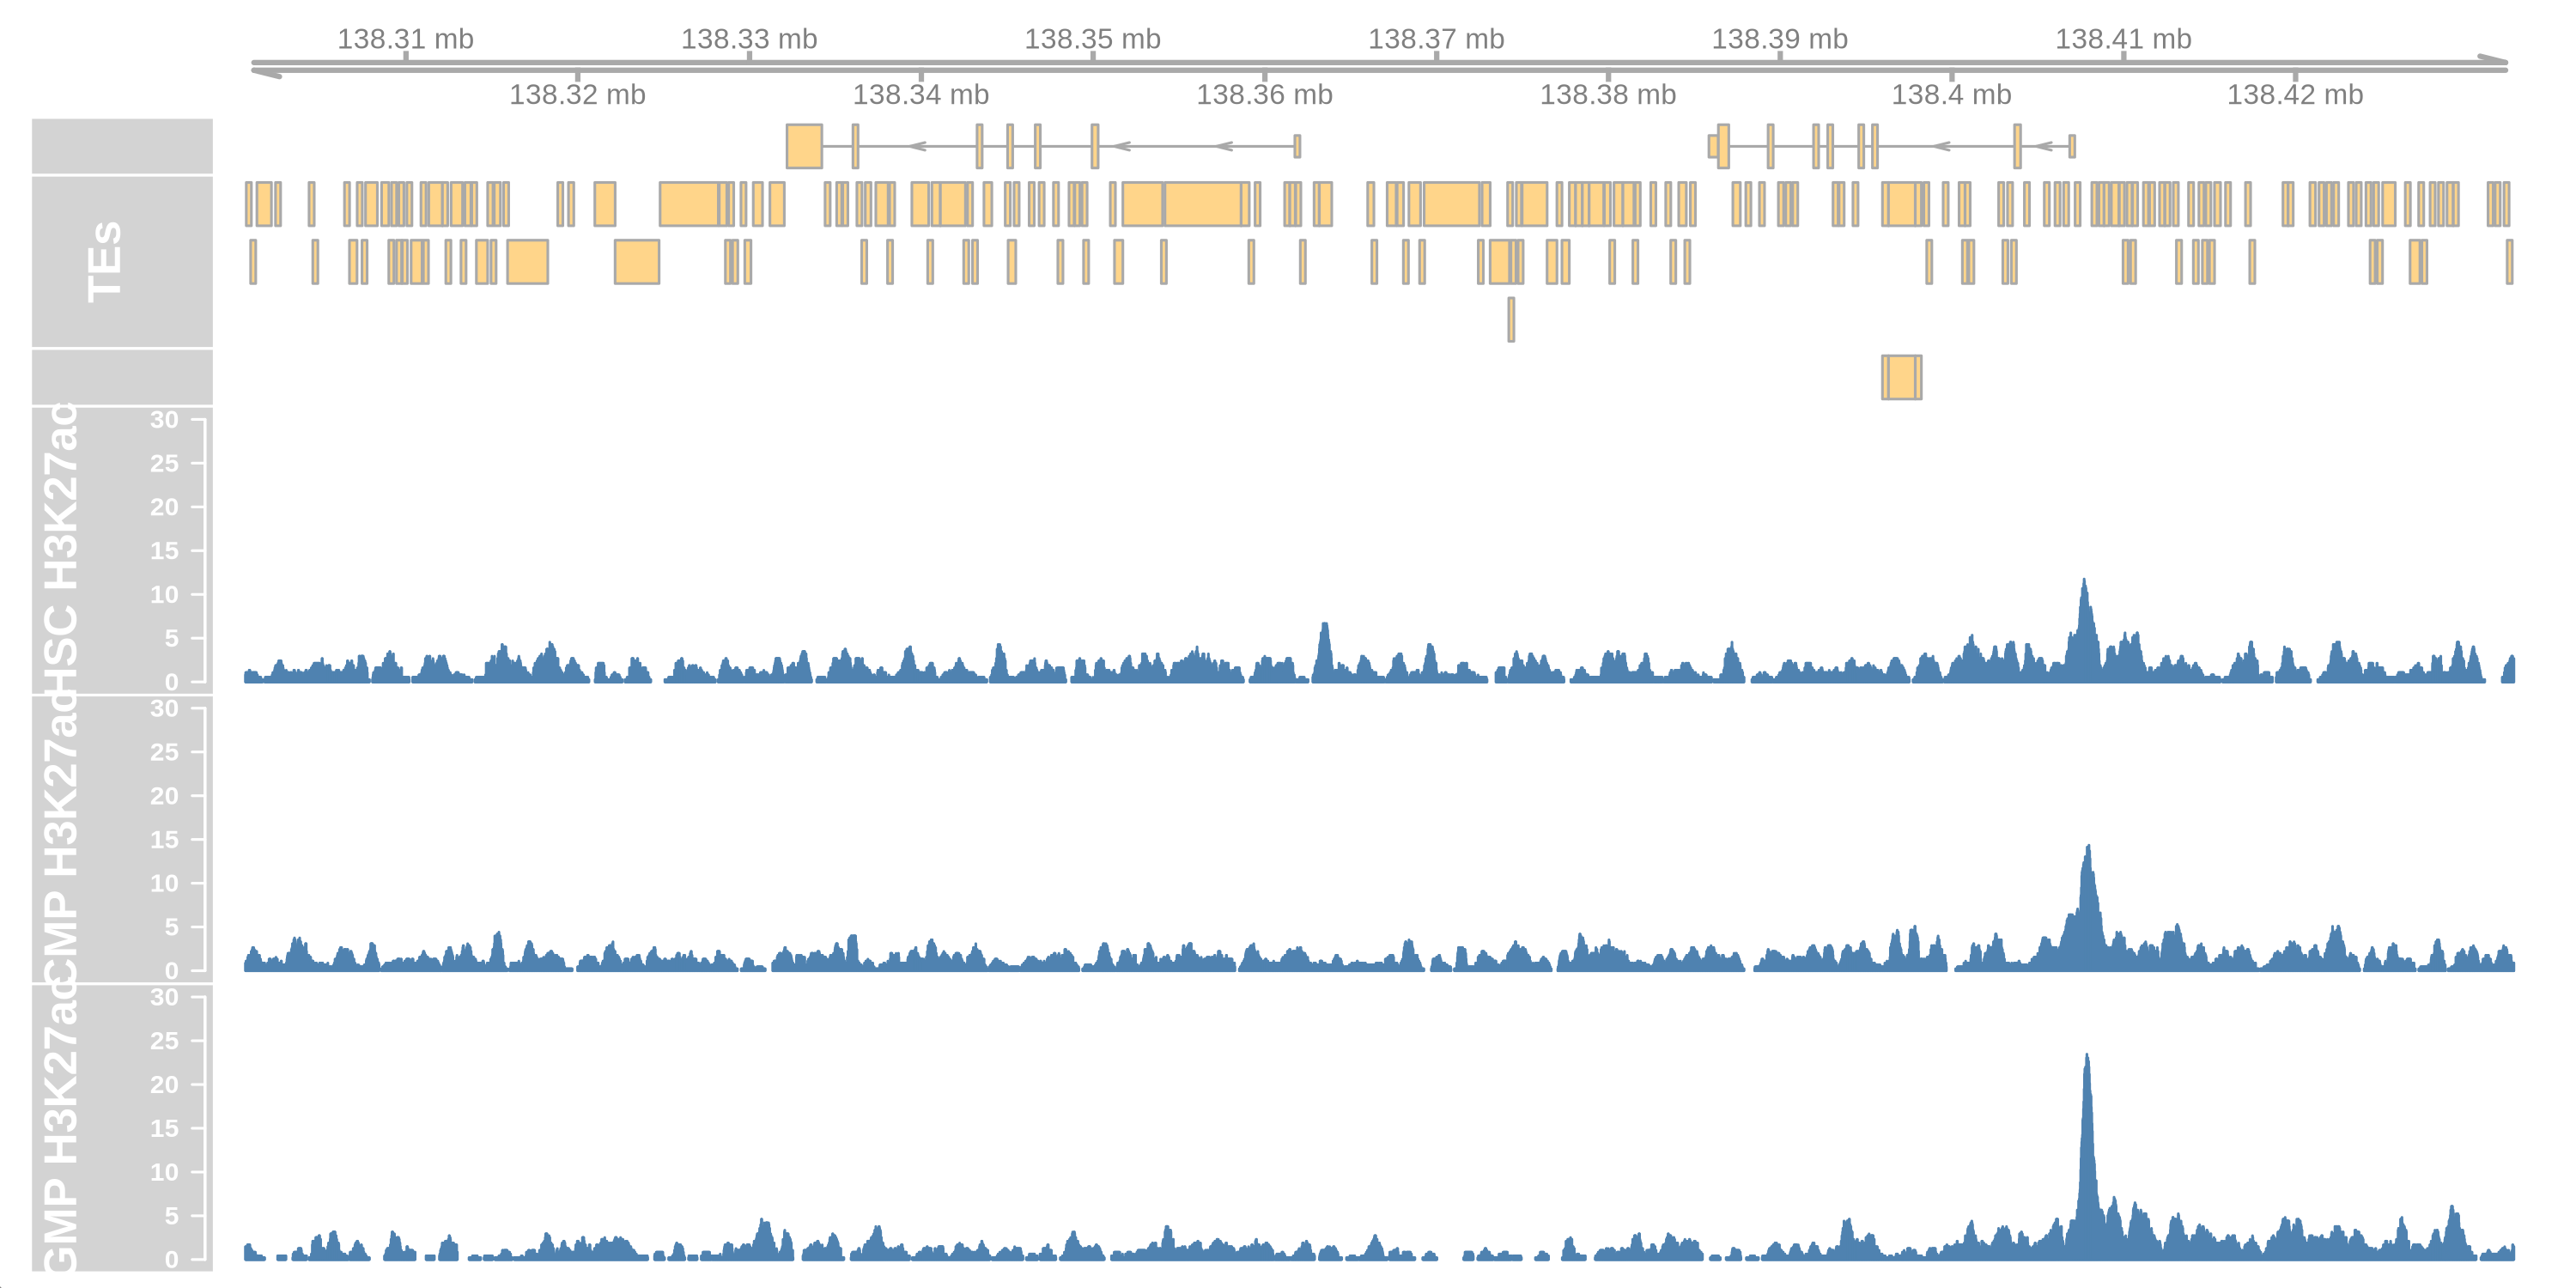

In [260]:
ii_chr = 'chr6'
ii_start = 138300659
ii_end = 138432712
res = as.data.table(dbFetch(dbSendQuery(con, paste0("SELECT * FROM t2t WHERE chromosome = '", ii_chr, "' and start > ", ii_start, " and end < ", ii_end)) ) )
setnames(res, 'tx_id', 'transcript')
setnames(res, 'gene_id', 'gene')
res[, exon := paste0(transcript, '.', exon_nn ) ]
res[, symbol := gene ]
res[, feat := feature ]
res[feat == 'CDS', feature := 'CDS' ]
res[feat == '5UTR', feature := 'utr5' ]
res[feat == '3UTR', feature := 'utr3' ]
# select representive gene transcript
tx_sel = res %>% group_by(symbol) %>% filter(feat == 'transcript') %>% slice_max(max_exon, n = 1, with_ties = FALSE) %>% ungroup() %>% pull(transcript)
res = res[grep('exon', feat, invert = T), ]
res = res[transcript %in% tx_sel, ]
res = res[feature %in% c('CDS', 'utr5', 'utr3'), ]
res_te = as.data.table(dbFetch(dbSendQuery(con, paste0("SELECT * FROM t2t_te WHERE chromosome = '", ii_chr, "' and start > ", ii_start, " and end < ", ii_end))))
head(res_te) 

ccs <- c("#4f82b0", "#7bb7d4", "#b3d6e7", 
         "#e84e3e", "#f76d50", "#f89f4d", 
         "#6acc1f", "#a8d76a", "#d2e4a6", 
         "#e1c700", "#f7d94c", "#fbfbc5")

# identify the DEG TE gene around IFNGR1
tmp = ann[geneId == 'IFNGR1', ]
tmp[, tag := paste0(name, '__', start, '__', end) ]
tmp = tmp[!duplicated(tag), ]
tmp = makeGRangesFromDataFrame(tmp, keep.extra.columns = T) 
deg_te = GeneRegionTrack(tmp, name = 'DEG TE')
deg_te_gr = makeGRangesFromDataFrame(data.frame(chr = 'chr6', start = min(start(tmp)) + 500, end = max(end(tmp)) ))

# Path to the BigWig file from ATACSeq
bigwigFiles = dsn_sel2$bigwig_file

# Create a DataTrack from the BigWig file
bw_hsc_fname = dsn_sample[cell_type == 'HSC' & assay == 'ChIP' & antibody == 'H3K27ac', bigwig_file]
hsc_bwTrack <- DataTrack(range = bw_hsc_fname, type = "h", name = "HSC H3K27ac", ylim = c(0, 30), col = ccs[1])
bw_cmp_fname = dsn_sample[cell_type == 'CMP' & assay == 'ChIP' & antibody == 'H3K27ac', bigwig_file]
cmp_bwTrack <- DataTrack(range = bw_cmp_fname, type = "h", name = "CMP H3K27ac", ylim = c(0, 30), col = ccs[1])
bw_gmp_fname = dsn_sample[cell_type == 'GMP' & assay == 'ChIP' & antibody == 'H3K27ac', bigwig_file]
gmp_bwTrack <- DataTrack(range = bw_gmp_fname, type = "h", name = "GMP H3K27ac", ylim = c(0, 30), col = ccs[1])

ax <- GenomeAxisTrack(name = 'chr6')

gene = GeneRegionTrack(res, name = 'IFNGR1') 
gene_te = GeneRegionTrack(res_te, collapse_rows = T, name = 'TEs')

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)
pdf(file = 'plot/tracks.pdf', width = 10, height = 5)
plotTracks(
    list(ax, gene, gene_te, deg_te, 
         hsc_bwTrack, cmp_bwTrack, gmp_bwTrack), 
    from = 138385847, to = 138407049, extend.right = 1000, extend.left = 1000)
dev.off()

plotTracks(
    list(ax, gene, gene_te, deg_te, 
         hsc_bwTrack, cmp_bwTrack, gmp_bwTrack), 
    chromosome = ii_chr, from = ii_start, to = ii_end, extend.right = 1000, extend.left = 1000)


# export table

In [815]:
save.image('nb_enhancer_resource_list_May25.rdata')

In [19]:
load('nb_enhancer_resource_list_May25.rdata')

In [117]:
#fwrite(dsn_sample, file = 'dsn_sample_atac_may28.tsv', sep = '\t')
fwrite(dsn_sample, file = 'dsn_sample_atac_nov19.tsv', sep = '\t')


In [115]:
fwrite(dsn_sample, file = 'dsn_sample_atac_oct23.tsv', sep = '\t')


In [17]:
dsn_sample = fread('~/WenhuoHu/TE/enhancer/dsn_sample_atac_oct23.tsv')

In [18]:
dsn_chip = fread('~/WenhuoHu/TE/enhancer/dsn_sample_atac_oct23.tsv')

In [ ]:
dsn_sample[assay == 'ChIPmentation' & cell_type == 'MEP' & antibody == 'CTCF',]
dsn_chip[assay == 'ChIPmentation' & cell_type == 'MEP' & antibody == 'CTCF',]

In [20]:
ls()

[1] "add_ann"           "add_gene_list"     "aml_fuse"          "aml_genes"         "aml_mut"           "base_dir"          "cell_lines"        "chrom_size_file"   "cmd"              
[10] "combn_fun"         "cpm_fun"           "create_named_list" "cut_quantile"      "data_dir"          "deg_fun"           "deg_fun2"          "deg_local_fun"     "deg_telocal_fun"  
[19] "dsn"               "dsn_atac"          "dsn_bloodx"        "dsn_chip"          "dsn_gse231486"     "dsn_sample"        "dsn2"              "enh_dir"           "fgsea_fun"        
[28] "genome_fun"        "graph_dt"          "head2"             "heatmap_fun"       "logcpm_fun"        "path"              "pathway_fun"       "pca_fun"           "plotdat"          
[37] "plotdat0"          "plotdat1"          "plotdat2"          "PP"                "python_dir"        "qvalue_cutoff"     "ranking_fun"       "read_file"         "ref_dir"          
[46] "save_file"         "scale_fun"         "share_dir"         "sif"               "size"              "size_fun"          "species"           "sra"               "surv_fun"         
[55] "surv_sum_fun"      "tail2"             "te_dt"             "tmp"               "tmp1"              "tmp2"              "tmp3"              "tmp4"              "txdb"             
[64] "xx"